In [1]:
from inference.run_inference import scrape_and_predict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sentiment_model.evaluation import run_evaluation
import pandas as pd
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sentiment_model.data_utils.tweet_dataset import tokenize, process_token_list
from tqdm.notebook import tqdm

## Model evaluation

In [2]:
predictions, targets = run_evaluation()

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Test set accuracy: 0.7164686322212219


In [3]:
def create_test_df(preds, targets):
    preds = np.argmax(preds, axis=1)
    labels = ['negative', 'neutral', 'positive']
    text_labels = [labels[int(i)] for i in preds]
    target_labels = [labels[int(i)] for i in targets]

    return pd.DataFrame({"target": target_labels, "predictions": text_labels})

test_df = create_test_df(predictions, targets)

In [4]:
def plot_bar(df, x_col, y_col):
    fig, ax = plt.subplots(1,1)
    ax.plot(df[x_col], df[y_col])

    return

def plot_label_count(df):
    counts = [np.sum(np.array(df['target']) == i) for i in np.unique(df['target'])]

    fig, ax = plt.subplots(1,1)

    ax.bar(np.unique(df['target']), counts)

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    labels = ['negative', 'neutral', 'positive']
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)


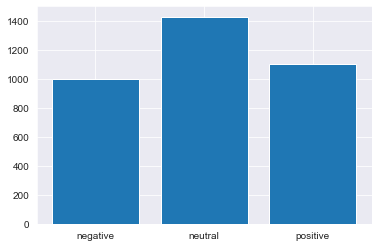

In [5]:
plot_label_count(test_df)

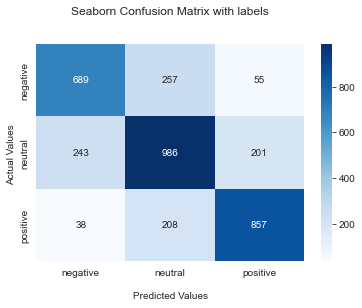

In [6]:
plot_confusion_matrix(confusion_matrix(test_df['target'], test_df['predictions']))

## Scrape and predict sentiment

In [23]:
keyword="China"

In [7]:
sentiment, text_sentiment, tweet_df = scrape_and_predict(keyword=keyword, start_date="2020-01-30", end_date="now", max_tweets=10000)

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

10001it [09:32, 17.45it/s]                          


  0%|          | 0/10001 [00:00<?, ?it/s]

In [8]:
tweet_df['sentiment_label'] = text_sentiment
tweet_df['text_length'] = [len(text) for text in tweet_df['rawContent']]

In [14]:
def plot_sentiment(tweet_df):
    sent_cl = np.unique(tweet_df["sentiment_label"])

    counts = [np.sum(np.array(tweet_df['sentiment_label']) == cl) for cl in sent_cl]

    fig, ax = plt.subplots(1,1)

    ax.bar(sent_cl, counts)
    return

def plot_text_lengths(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'negative'], shade=True, color="r", ax=ax, label="negative")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'neutral'], shade=True, color="b", ax=ax, label="neutral")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'positive'], shade=True, color="g", ax=ax, label="positive")
    ax.set_xlim(-10, 500)
    ax.legend()
    ax.set_title("Text length per sentiment label")

def plot_date_dist(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.histplot(tweet_df['date'], ax=ax)

    ax.tick_params(axis='x', rotation=60)
    ax.set_title("Tweet frequency over time")

In [194]:
def plot_stacked_bar(tweet_df):
    sentiment_month = pd.DataFrame(tweet_df.groupby([tweet_df.date.dt.year, tweet_df.date.dt.month, 'sentiment_label']).size())

    years = []
    months = []
    sentiments = []

    datetime_col = pd.to_datetime({'year': [i[0] for i in list(sentiment_month.index)],
                             'month': [i[1] for i in list(sentiment_month.index)],
                             'day': [1 for i in range(len(sentiment_month.index))]})
    sentiments = [i[2] for i in list(sentiment_month.index)]
    sentiment_month = sentiment_month.reset_index(drop=True)
    sentiment_month["date"] = datetime_col
    sentiment_month["sentiment"] = sentiments

    totals = sentiment_month.groupby("date").sum()[0]

    def get_percentage(x):
        return x[0] / totals[x['date']]

    sentiment_month['ratio'] = sentiment_month.apply(get_percentage, axis=1)

    negative = sentiment_month[sentiment_month['sentiment'] == 'negative']['ratio']
    neutral = sentiment_month[sentiment_month['sentiment'] == 'neutral']['ratio']
    positive = sentiment_month[sentiment_month['sentiment'] == 'positive']['ratio']

    return sentiment_month

In [195]:
plot_stacked_bar(tweet_df)#.groupby("date")#.sum()[0]

,0,date,sentiment,ratio
0,241,2020-03-01,negative,0.308184
1,471,2020-03-01,neutral,0.602302
2,70,2020-03-01,positive,0.089514
3,231,2020-04-01,negative,0.266129
4,538,2020-04-01,neutral,0.619816
...,...,...,...,...
91,156,2022-09-01,neutral,0.681223
92,29,2022-09-01,positive,0.126638
93,46,2022-10-01,negative,0.190871
94,171,2022-10-01,neutral,0.709544


In [166]:
sentiment_month = pd.DataFrame(tweet_df.groupby([tweet_df.date.dt.year, tweet_df.date.dt.month, 'sentiment_label']).size())
sentiment_month = sentiment_month.reset_index(drop=True)

years = []
months = []
for (year, month, _) in list(sentiment_month.index):
    years.append(year)
    months.append(month)



TypeError: cannot unpack non-iterable int object

In [ ]:
datetime_col = pd.to_datetime({'year': [tup[0] for tup in list(sentiment_month.index)],
                         'month': [tup[1] for i in list(sentiment_month.index)],
                         'day': [1 for i in range(len(sentiment_month.index))]})

In [154]:
sentiment_month = pd.DataFrame(tweet_df.groupby([tweet_df.date.dt.year, tweet_df.date.dt.month, 'sentiment_label']).size())
[i[0] for i in list(sentiment_month.index)]

[2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2020,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2021,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022,
 2022]

In [145]:
tweet_df

,id,date,rawContent,sourceLabel,user,sentiment_label,text_length
0,1585950526541221888,2022-10-28 11:04:05+00:00,@HarxMLeth Oh boii.\n\nIt is illegal in China ...,Twitter for Android,WinterHE,neutral,286
1,1585941134723158017,2022-10-28 10:26:46+00:00,"I've been working furiously on my project, rev...",Twitter Web App,DesperaDody,neutral,279
2,1585931006220988417,2022-10-28 09:46:31+00:00,".@joshrogin: Until now, the CCP attempted to m...",Twitter for iPhone,Walker_CT,neutral,277
3,1585926858322808832,2022-10-28 09:30:02+00:00,@YoucanAxel @mik_petersen @AndreasSteno it’s n...,Twitter for iPhone,DrahoslavP,positive,229
4,1585908227572727809,2022-10-28 08:16:00+00:00,"NIO, hotel firm Huazhu Group team up on chargi...",SocialChamp IO,traveldailycn,neutral,210
...,...,...,...,...,...,...,...
9996,1239104571835731968,2020-03-15 08:22:06+00:00,@desimojito China publishes footage of surveil...,Twitter for Android,MohithParekh,neutral,315
9997,1239100268815540226,2020-03-15 08:05:00+00:00,I have spoken to someone in China virtually ev...,Twitter for iPhone,0121_pedro,negative,277
9998,1239088638878601217,2020-03-15 07:18:47+00:00,"@AusOpinion @australian Until now, not just po...",Twitter for iPhone,vincentwangx,neutral,268
9999,1239083227949694976,2020-03-15 06:57:17+00:00,"@little_li23x @CarolOfNJ @WHO @Twitter Rumor, ...",Twitter for iPhone,daisyljl,neutral,156


In [144]:
sentiment_month.reset_index(drop=True)

,0
0,241
1,471
2,70
3,231
4,538
...,...
91,156
92,29
93,46
94,171


In [88]:
tweet_df.rename(columns={"date":"date2"})

,id,date2,rawContent,sourceLabel,user,sentiment_label,text_length
0,1585950526541221888,2022-10-28 11:04:05+00:00,@HarxMLeth Oh boii.\n\nIt is illegal in China ...,Twitter for Android,WinterHE,neutral,286
1,1585941134723158017,2022-10-28 10:26:46+00:00,"I've been working furiously on my project, rev...",Twitter Web App,DesperaDody,neutral,279
2,1585931006220988417,2022-10-28 09:46:31+00:00,".@joshrogin: Until now, the CCP attempted to m...",Twitter for iPhone,Walker_CT,neutral,277
3,1585926858322808832,2022-10-28 09:30:02+00:00,@YoucanAxel @mik_petersen @AndreasSteno it’s n...,Twitter for iPhone,DrahoslavP,positive,229
4,1585908227572727809,2022-10-28 08:16:00+00:00,"NIO, hotel firm Huazhu Group team up on chargi...",SocialChamp IO,traveldailycn,neutral,210
...,...,...,...,...,...,...,...
9996,1239104571835731968,2020-03-15 08:22:06+00:00,@desimojito China publishes footage of surveil...,Twitter for Android,MohithParekh,neutral,315
9997,1239100268815540226,2020-03-15 08:05:00+00:00,I have spoken to someone in China virtually ev...,Twitter for iPhone,0121_pedro,negative,277
9998,1239088638878601217,2020-03-15 07:18:47+00:00,"@AusOpinion @australian Until now, not just po...",Twitter for iPhone,vincentwangx,neutral,268
9999,1239083227949694976,2020-03-15 06:57:17+00:00,"@little_li23x @CarolOfNJ @WHO @Twitter Rumor, ...",Twitter for iPhone,daisyljl,neutral,156


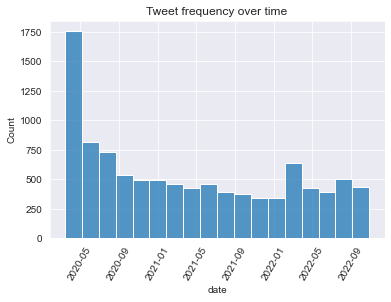

In [16]:
plot_date_dist(tweet_df)

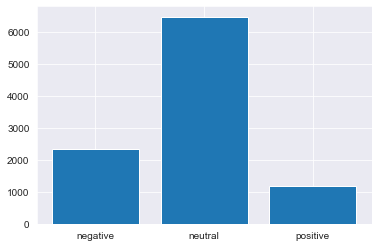

In [17]:
plot_sentiment(tweet_df)

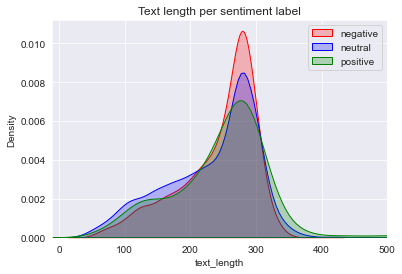

In [18]:
plot_text_lengths(tweet_df)

In [33]:
def get_word_cloud_text(tweet_df):
    tweet_tokens = []
    for tweet in tqdm(tweet_df['rawContent']):
        tweet_tokens.extend(tokenize(tweet))

    return " ".join(token for token in tweet_tokens)


def get_word_cloud_text(tweet_df):
    all_tweets = " ".join(tweet for tweet in tweet_df['rawContent'])
    all_tweets_tokens = process_token_list(tokenize(all_tweets))
    return " ".join(token for token in all_tweets_tokens)


def plot_word_cloud(tweet_df, keyword, sentiment_class=None):
    stopwords = set(STOPWORDS)
    stopwords.update({"<url>", "<user>", "user", "s", "url", "hashtag", keyword})
    word_cloud = WordCloud(stopwords=stopwords, min_word_length=2, width=800, height=400)

    if not sentiment_class:
        text = get_word_cloud_text(tweet_df)
    else:
        text = get_word_cloud_text(tweet_df[tweet_df['sentiment_label'] == sentiment_class])

    word_cloud.generate(text)

    fig, ax = plt.subplots(1,1, figsize=(20,40))
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")
    plt.show()



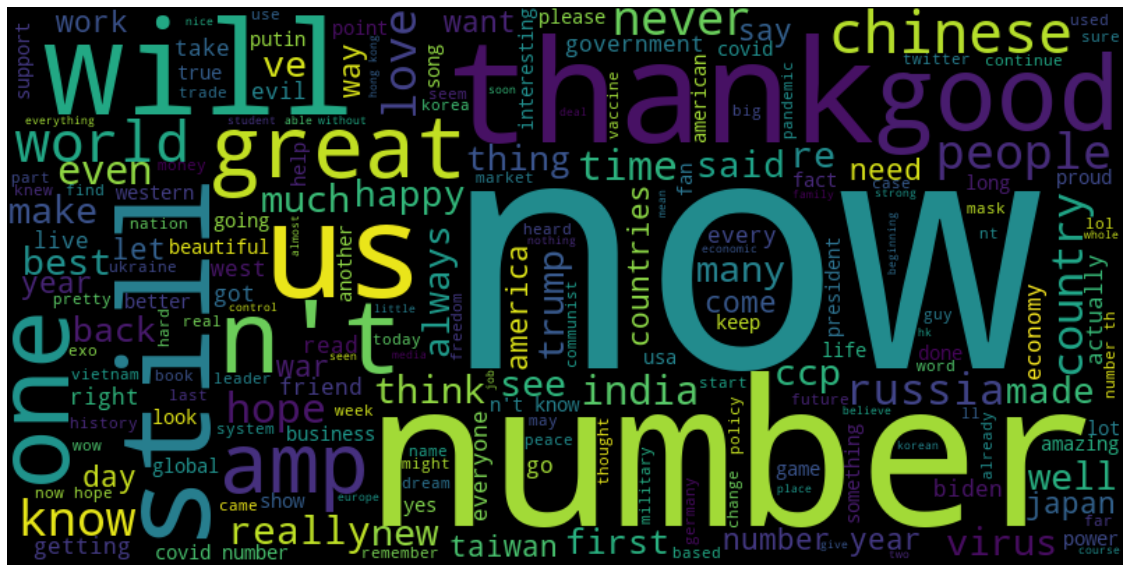

In [34]:
plot_word_cloud(tweet_df, keyword, "positive")

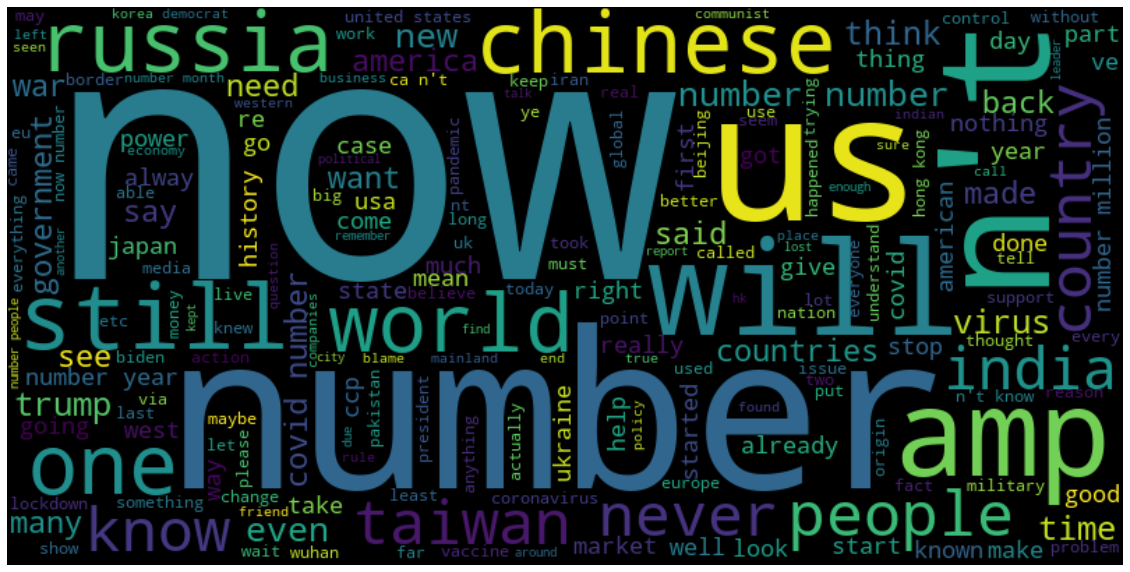

In [35]:
plot_word_cloud(tweet_df, keyword, "neutral")

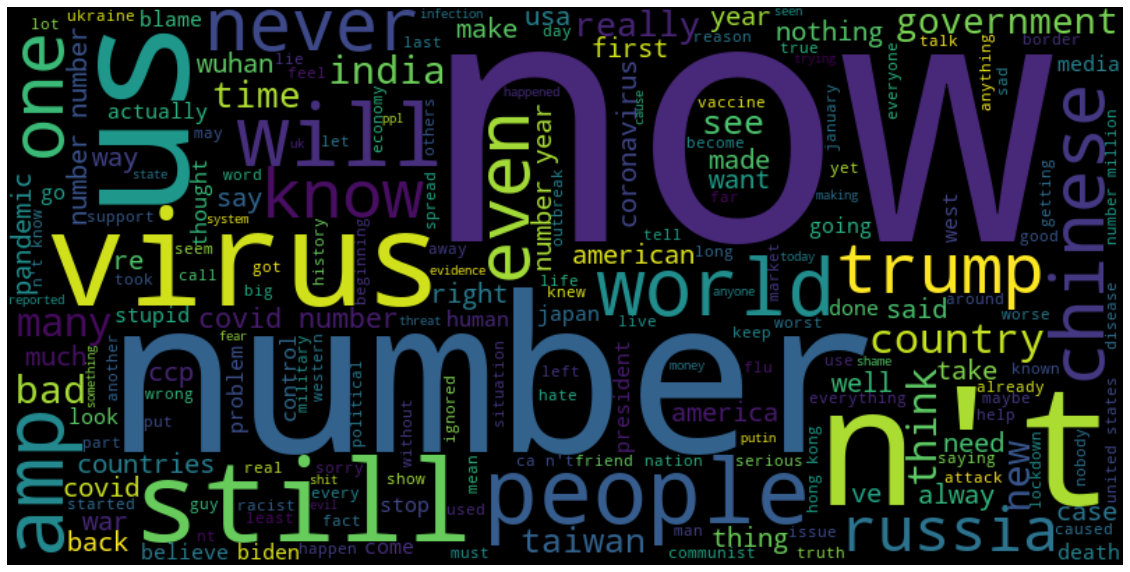

In [36]:
plot_word_cloud(tweet_df, keyword, "negative")